<a href="https://colab.research.google.com/github/aaronrohan7/Drainage-Blockage-Detection/blob/main/Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gspread pandas folium gspread_dataframe

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# === SETTINGS ===

csv_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTT8R1bIKpoRo77dBVTFrhKfrElezSEpeuuT4elk-u995O042l4BxlY7_Ohc84dBhQNnPkDnH2wCHsJ/pub?output=csv"

# === READ GOOGLE SHEET ===
df = pd.read_csv(csv_url)

# === CALCULATE DAYS SINCE LAST MAINTENANCE ===
df['Last_Maintenance_Date'] = pd.to_datetime(df['Last_Maintenance_Date'], errors='coerce')
today = datetime.now()
df['Days_Since_Last_Maintenance'] = (today - df['Last_Maintenance_Date']).dt.days

# === CALCULATE URGENCY SCORE ===
# Formula: (Blockage_% * 0.6) + (Load_% * 0.4) + (Days_Since_Last_Maintenance / 10)
df['Urgency_Score'] = (df['Blockage_%'] * 0.6) + (df['Load_%'] * 0.4) + (df['Days_Since_Last_Maintenance'] / 10)
df['Urgency_Score'] = df['Urgency_Score'].round(2)

# === RECOMMENDED ACTION ===
def recommend_action(row):
    if row['Urgency_Score'] >= 80:
        return "Immediate Maintenance"
    elif row['Urgency_Score'] >= 50:
        return "Schedule Soon"
    else:
        return "Monitor Only"

df['Recommended_Action'] = df.apply(recommend_action, axis=1)

# === DISPLAY UPDATED DATA ===
df


,Drain_ID,Latitude,Longitude,Location_Name,Blockage_%,Last_Maintenance_Date,Load_%,Predicted_Maintenance,Days_Since_Last_Maintenance,Urgency_Score,Recommended_Action
0,D001,12.9716,77.5946,MG Road,30,2025-07-10,50,No,33,41.3,Monitor Only
1,D002,12.9352,77.6245,Koramangala,75,2025-06-20,85,Yes,53,84.3,Immediate Maintenance
2,D003,12.9260,77.6762,Indiranagar,55,2025-05-15,70,Yes,89,69.9,Schedule Soon
3,D004,12.9719,77.6412,Ulsoor Lake,20,2025-08-01,40,No,11,29.1,Monitor Only
4,D005,12.9081,77.6476,BTM Layout,80,2025-04-10,90,Yes,124,96.4,Immediate Maintenance


Updated Table:


,Drain_ID,Latitude,Longitude,Location_Name,Blockage_%,Last_Maintenance_Date,Load_%,Predicted_Maintenance,Days_Since_Last_Maintenance,Urgency_Score,Recommended_Action
0,D001,12.9716,77.5946,MG Road,30,2025-07-10,50,No,33,34.6,Safe
1,D002,12.9352,77.6245,Koramangala,75,2025-06-20,85,Yes,53,72.6,Urgent Maintenance Required
2,D003,12.9260,77.6762,Indiranagar,55,2025-05-15,70,Yes,89,64.8,Schedule Maintenance Soon
3,D004,12.9719,77.6412,Ulsoor Lake,20,2025-08-01,40,No,11,22.2,Safe
4,D005,12.9081,77.6476,BTM Layout,80,2025-04-10,90,Yes,124,90.8,Urgent Maintenance Required


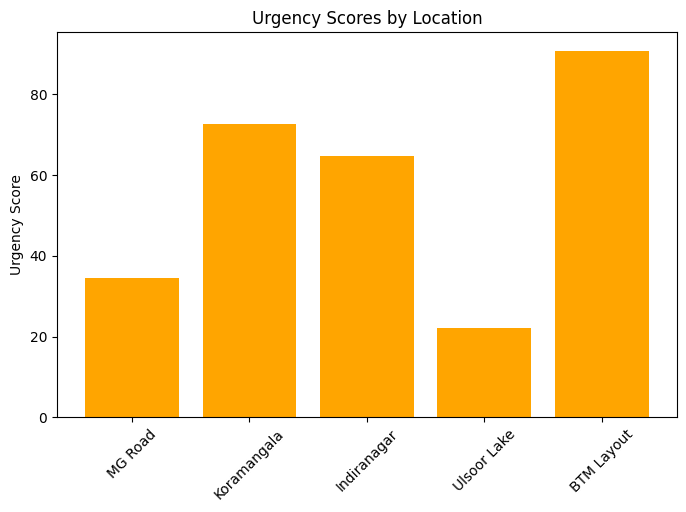

In [ ]:
!pip install folium matplotlib pandas

import pandas as pd
import folium
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display

# =====================
# 1. GOOGLE SHEET (READ-ONLY)
# =====================
# Replace with your "Publish to Web" CSV link
csv_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTT8R1bIKpoRo77dBVTFrhKfrElezSEpeuuT4elk-u995O042l4BxlY7_Ohc84dBhQNnPkDnH2wCHsJ/pub?output=csv"

# =====================
# 2. FETCH DATA
# =====================
df = pd.read_csv(csv_url)

# Strip spaces from column names just in case
df.columns = df.columns.str.strip()

# =====================
# 3. CALCULATE COLUMNS
# =====================
df["Last_Maintenance_Date"] = pd.to_datetime(df["Last_Maintenance_Date"], errors='coerce')
df["Days_Since_Last_Maintenance"] = (datetime.now() - df["Last_Maintenance_Date"]).dt.days

df["Urgency_Score"] = (
    df["Blockage_%"] * 0.6 +
    df["Days_Since_Last_Maintenance"] * 0.2 +
    df["Load_%"] * 0.2
)

def recommend_action(score):
    if score > 70:
        return "Urgent Maintenance Required"
    elif score > 40:
        return "Schedule Maintenance Soon"
    else:
        return "Safe"

df["Recommended_Action"] = df["Urgency_Score"].apply(recommend_action)

# =====================
# 4. DISPLAY IN TABLE
# =====================
print("Updated Table:")
display(df)

# =====================
# 5. URGENCY SCORE BAR CHART
# =====================
plt.figure(figsize=(8,5))
plt.bar(df["Location_Name"], df["Urgency_Score"], color="orange")
plt.xticks(rotation=45)
plt.ylabel("Urgency Score")
plt.title("Urgency Scores by Location")
plt.show()

# =====================
# 6. MAP WITH COLORED MARKERS
# =====================
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=12)

for _, row in df.iterrows():
    if row["Recommended_Action"] == "Urgent Maintenance Required":
        color = "red"
    elif row["Recommended_Action"] == "Schedule Maintenance Soon":
        color = "orange"
    else:
        color = "green"

    popup_html = f"""
    <b>{row['Location_Name']}</b><br>
    Blockage: {row['Blockage_%']}%<br>
    Load: {row['Load_%']}%<br>
    Days Since Maintenance: {row['Days_Since_Last_Maintenance']}<br>
    Urgency Score: {row['Urgency_Score']:.2f}<br>
    Action: {row['Recommended_Action']}
    """
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=popup_html,
        icon=folium.Icon(color=color)
    ).add_to(m)

m.save("drain_map.html")
m

Raw Sensor Data:
   Distance to water  Water Level
0             113.39          0.0
1             113.07          0.0
2             113.51          0.0
3             113.07          0.0
4             167.69          0.0

Updated data saved to drainage_updated.csv


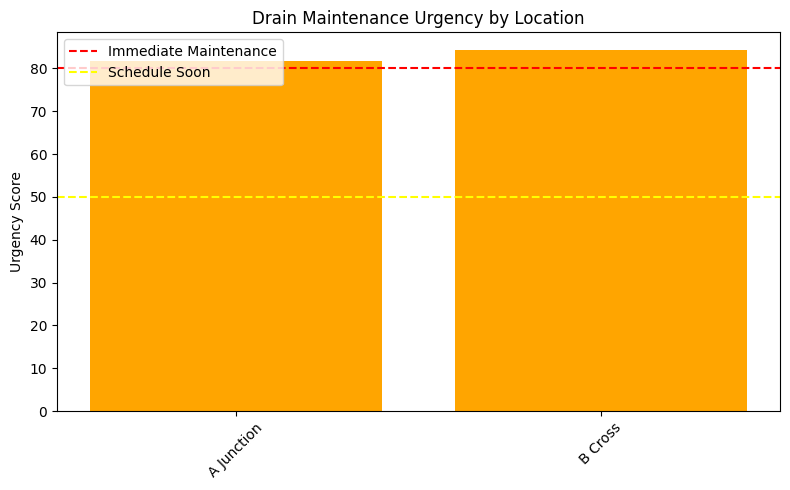

Map saved to drain_map.html


In [ ]:
# ==============================
# Drainage Maintenance Dashboard (Fixed)
# ==============================
# Author: Your Team
# Description: Reads Arduino water level data, computes maintenance metrics,
# and visualizes results on a chart + map.

import pandas as pd
import folium
import matplotlib.pyplot as plt
from datetime import datetime

# ---------- CONFIG ----------
INPUT_CSV = "/content/cleaned_data.csv"    # Arduino CSV file
OUTPUT_CSV = "drainage_updated.csv"
OUTPUT_MAP = "drain_map.html"

# ---------- STEP 1: READ SENSOR DATA ----------
df_sensor = pd.read_csv(INPUT_CSV)
print("Raw Sensor Data:")
print(df_sensor.head())

expected_cols = ["Distance to water", "Water Level"]
if not all(col in df_sensor.columns for col in expected_cols):
    raise ValueError(f"CSV must contain: {expected_cols}")

# ---------- STEP 2: ADD STATIC INFO ----------
static_info = pd.DataFrame([
    {"Location_Name": "A Junction", "Latitude": 12.9716, "Longitude": 77.5946, "Last_Maintenance_Date": "2025-09-01"},
    {"Location_Name": "B Cross",    "Latitude": 12.9750, "Longitude": 77.5900, "Last_Maintenance_Date": "2025-08-20"},
])

# If the sensor data has more rows than static info, repeat static info cyclically
if len(df_sensor) != len(static_info):
    static_info = pd.concat([static_info] * ((len(df_sensor) // len(static_info)) + 1), ignore_index=True).iloc[:len(df_sensor)]

# Merge both side-by-side
df = pd.concat([static_info.reset_index(drop=True), df_sensor.reset_index(drop=True)], axis=1)

# Ensure Location_Name is a string (important for bar chart)
df["Location_Name"] = df["Location_Name"].astype(str)

# ---------- STEP 3: CALCULATE ADDITIONAL METRICS ----------
df["Last_Maintenance_Date"] = pd.to_datetime(df["Last_Maintenance_Date"], errors="coerce")
df["Days_Since_Last_Maintenance"] = (datetime.now() - df["Last_Maintenance_Date"]).dt.days.fillna(0)

# Estimate blockage/load (adjust as needed)
df["Blockage_%"] = df["Water Level"].apply(lambda x: min(max(x * 4, 0), 100))        # scaled from water level
df["Load_%"] = df["Distance to water"].apply(lambda x: max(0, min(100, 100 - x)))    # inverse relationship

# Compute urgency score
df["Urgency_Score"] = (df["Blockage_%"] * 0.5) + (df["Load_%"] * 0.3) + (df["Days_Since_Last_Maintenance"] * 0.2)
df["Urgency_Score"] = df["Urgency_Score"].round(2)

def recommend_action(score):
    if score >= 80:
        return "🚨 Immediate Maintenance Required"
    elif score >= 50:
        return "⚠️ Schedule Maintenance Soon"
    else:
        return "✅ Safe / Monitor Only"

df["Recommended_Action"] = df["Urgency_Score"].apply(recommend_action)

# ---------- STEP 4: SAVE UPDATED DATA ----------
df.to_csv(OUTPUT_CSV, index=False)
print(f"\nUpdated data saved to {OUTPUT_CSV}")

# ---------- STEP 5: VISUALIZE ----------
plt.figure(figsize=(8,5))
plt.bar(df["Location_Name"], df["Urgency_Score"].astype(float), color="orange")
plt.axhline(80, color='red', linestyle='--', label='Immediate Maintenance')
plt.axhline(50, color='yellow', linestyle='--', label='Schedule Soon')
plt.xticks(rotation=45)
plt.ylabel("Urgency Score")
plt.title("Drain Maintenance Urgency by Location")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- STEP 6: MAP ----------
center = [df["Latitude"].mean(), df["Longitude"].mean()]
m = folium.Map(location=center, zoom_start=13)

for _, row in df.iterrows():
    if "Immediate" in row["Recommended_Action"]:
        color = "red"
    elif "Schedule" in row["Recommended_Action"]:
        color = "orange"
    else:
        color = "green"

    popup = (
        f"<b>{row['Location_Name']}</b><br>"
        f"Water Level: {row['Water Level']} cm<br>"
        f"Distance: {row['Distance to water']} cm<br>"
        f"Urgency Score: {row['Urgency_Score']}<br>"
        f"Action: {row['Recommended_Action']}"
    )

    folium.Marker(
        [row["Latitude"], row["Longitude"]],
        popup=popup,
        icon=folium.Icon(color=color)
    ).add_to(m)

m.save(OUTPUT_MAP)
print(f"Map saved to {OUTPUT_MAP}")


In [ ]:
import pandas as pd
import re

# Read the CSV file (replace 'input.csv' with your actual file name)
with open('/content/drainage.csv', 'r') as f:
    lines = f.readlines()

# Create empty lists to store values
distances = []
levels = []

# Extract numerical values using regex
for line in lines:
    distance_match = re.search(r"Distance to water:\s*([\d.]+)", line)
    level_match = re.search(r"Water Level:\s*([\d.]+)", line)

    if distance_match and level_match:
        distances.append(float(distance_match.group(1)))
        levels.append(float(level_match.group(1)))

# Create DataFrame
df = pd.DataFrame({
    'Distance to water': distances,
    'Water Level': levels
})

# Save cleaned data to a new CSV file
df.to_csv('cleaned_data.csv', index=False)

print("✅ Data cleaned and saved to 'cleaned_data.csv'")
print(df.head())


✅ Data cleaned and saved to 'cleaned_data.csv'
   Distance to water  Water Level
0             113.39          0.0
1             113.07          0.0
2             113.51          0.0
3             113.07          0.0
4             167.69          0.0


Raw Sensor Data:
   Distance to water  Water Level
0             113.39          0.0
1             113.07          0.0
2             113.51          0.0
3             113.07          0.0
4             167.69          0.0

Updated data saved to drainage_updated.csv


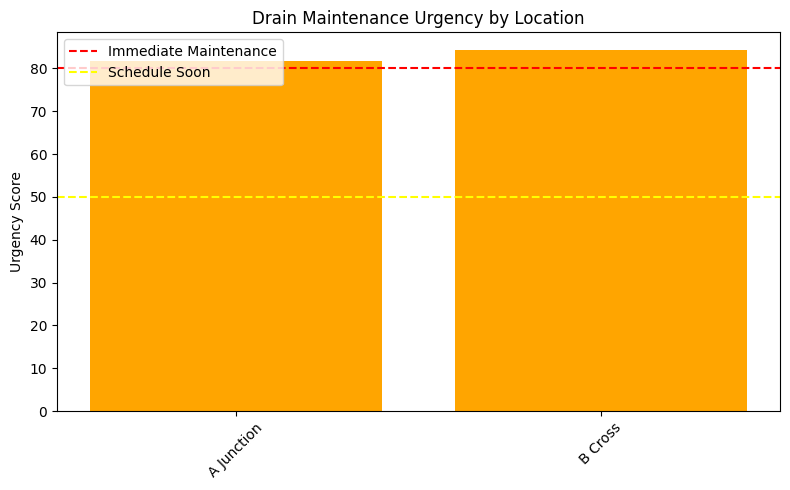

Map saved to drain_map.html


In [ ]:
# ==============================
# Drainage Maintenance Dashboard (Fixed)
# ==============================
# Author: Your Team
# Description: Reads Arduino water level data, computes maintenance metrics,
# and visualizes results on a chart + map.
#@title Final year project
import pandas as pd
import folium
import matplotlib.pyplot as plt
from datetime import datetime

# ---------- CONFIG ----------
INPUT_CSV = "/content/cleaned_data.csv"    # Arduino CSV file
OUTPUT_CSV = "drainage_updated.csv"
OUTPUT_MAP = "drain_map.html"

# ---------- STEP 1: READ SENSOR DATA ----------
df_sensor = pd.read_csv(INPUT_CSV)
print("Raw Sensor Data:")
print(df_sensor.head())

expected_cols = ["Distance to water", "Water Level"]
if not all(col in df_sensor.columns for col in expected_cols):
    raise ValueError(f"CSV must contain: {expected_cols}")

# ---------- STEP 2: ADD STATIC INFO ----------
static_info = pd.DataFrame([
    {"Location_Name": "A Junction", "Latitude": 12.9716, "Longitude": 77.5946, "Last_Maintenance_Date": "2025-09-01"},
    {"Location_Name": "B Cross",    "Latitude": 12.9750, "Longitude": 77.5900, "Last_Maintenance_Date": "2025-08-20"},
])

# If the sensor data has more rows than static info, repeat static info cyclically
if len(df_sensor) != len(static_info):
    static_info = pd.concat([static_info] * ((len(df_sensor) // len(static_info)) + 1), ignore_index=True).iloc[:len(df_sensor)]

# Merge both side-by-side
df = pd.concat([static_info.reset_index(drop=True), df_sensor.reset_index(drop=True)], axis=1)

# Ensure Location_Name is a string (important for bar chart)
df["Location_Name"] = df["Location_Name"].astype(str)

# ---------- STEP 3: CALCULATE ADDITIONAL METRICS ----------
df["Last_Maintenance_Date"] = pd.to_datetime(df["Last_Maintenance_Date"], errors="coerce")
df["Days_Since_Last_Maintenance"] = (datetime.now() - df["Last_Maintenance_Date"]).dt.days.fillna(0)

# Estimate blockage/load (adjust as needed)
df["Blockage_%"] = df["Water Level"].apply(lambda x: min(max(x * 4, 0), 100))        # scaled from water level
df["Load_%"] = df["Distance to water"].apply(lambda x: max(0, min(100, 100 - x)))    # inverse relationship

# Compute urgency score
df["Urgency_Score"] = (df["Blockage_%"] * 0.5) + (df["Load_%"] * 0.3) + (df["Days_Since_Last_Maintenance"] * 0.2)
df["Urgency_Score"] = df["Urgency_Score"].round(2)

def recommend_action(score):
    if score >= 80:
        return "🚨 Immediate Maintenance Required"
    elif score >= 50:
        return "⚠️ Schedule Maintenance Soon"
    else:
        return "✅ Safe / Monitor Only"

df["Recommended_Action"] = df["Urgency_Score"].apply(recommend_action)

# ---------- STEP 4: SAVE UPDATED DATA ----------
df.to_csv(OUTPUT_CSV, index=False)
print(f"\nUpdated data saved to {OUTPUT_CSV}")

# ---------- STEP 5: VISUALIZE ----------
plt.figure(figsize=(8,5))
plt.bar(df["Location_Name"], df["Urgency_Score"].astype(float), color="orange")
plt.axhline(80, color='red', linestyle='--', label='Immediate Maintenance')
plt.axhline(50, color='yellow', linestyle='--', label='Schedule Soon')
plt.xticks(rotation=45)
plt.ylabel("Urgency Score")
plt.title("Drain Maintenance Urgency by Location")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- STEP 6: MAP ----------
center = [df["Latitude"].mean(), df["Longitude"].mean()]
m = folium.Map(location=center, zoom_start=13)

for _, row in df.iterrows():
    if "Immediate" in row["Recommended_Action"]:
        color = "red"
    elif "Schedule" in row["Recommended_Action"]:
        color = "yellow"
    else:
        color = "green"

    popup = (
        f"<b>{row['Location_Name']}</b><br>"
        f"Water Level: {row['Water Level']} cm<br>"
        f"Distance: {row['Distance to water']} cm<br>"
        f"Urgency Score: {row['Urgency_Score']}<br>"
        f"Action: {row['Recommended_Action']}"
    )

    folium.Marker(
        [row["Latitude"], row["Longitude"]],
        popup=popup,
        icon=folium.Icon(color=color)
    ).add_to(m)

m.save(OUTPUT_MAP)
display(m)
print(f"Map saved to {OUTPUT_MAP}")


In [ ]:
# @title Ongoing (extra)

import pandas as pd
import re
import folium
from IPython.display import display, HTML

# === READ AND PARSE CSV ===
csv_path = "/content/cleaned_data.csv"  # your Arduino CSV
raw_df = pd.read_csv(csv_path, header=None, names=["Raw_Data"])

# Extract numeric values from text
raw_df["Distance_to_Water_cm"] = raw_df["Raw_Data"].str.extract(r"Distance to water:\s*([\d.]+)").astype(float)
raw_df["Water_Level_cm"] = raw_df["Raw_Data"].str.extract(r"Water Level:\s*([\d.]+)").astype(float)

# Drop raw text
df = raw_df[["Distance_to_Water_cm", "Water_Level_cm"]].copy()

# === ADD/GENERATE OTHER COLUMNS ===
# Simulate GPS coordinates (optional - you can replace with actual fixed ones)
import random
lat_base, lon_base = 12.9716, 77.5946  # Example: Bangalore
df["Latitude"] = [lat_base + random.uniform(-0.001, 0.001) for _ in range(len(df))]
df["Longitude"] = [lon_base + random.uniform(-0.001, 0.001) for _ in range(len(df))]

# Add last maintenance date (simulate manually or random)
df["Last_Maintenance_Date"] = pd.date_range("2025-09-01", periods=len(df), freq="7D")

# === CALCULATE DAYS SINCE LAST MAINTENANCE ===
current_date = pd.Timestamp.now()
df["Days_Since_Last_Maintenance"] = (current_date - df["Last_Maintenance_Date"]).dt.days

# === URGENCY SCORE CALCULATION ===
def urgency_score(water_level, days_since):
    score = (water_level / 100) * 0.7 + (days_since / 30) * 0.3
    return min(score * 10, 10)

df["Urgency_Score"] = df.apply(
    lambda row: round(urgency_score(row["Water_Level_cm"], row["Days_Since_Last_Maintenance"]), 2),
    axis=1,
)

# === RECOMMENDED ACTION ===
def recommended_action(score):
    if score > 7:
        return "Immediate maintenance required"
    elif score > 4:
        return "Inspect soon"
    else:
        return "No immediate action needed"

df["Recommended_Action"] = df["Urgency_Score"].apply(recommended_action)

# === DISPLAY RESULTS TABLE ===
display(HTML("<h3>🔹 Road Drainage Maintenance - Live Data</h3>"))
display(df.style.background_gradient(subset=["Urgency_Score"], cmap="Reds"))

# === FOLIUM MAP ===
center = [df["Latitude"].mean(), df["Longitude"].mean()]
m = folium.Map(location=center, zoom_start=14)

for _, row in df.iterrows():
    popup = (
        f"💧 Water Level: {row['Water_Level_cm']} cm<br>"
        f"📅 Days Since Last Maintenance: {row['Days_Since_Last_Maintenance']}<br>"
        f"⚙️ Action: {row['Recommended_Action']}"
    )
    color = "red" if row["Urgency_Score"] > 7 else "orange" if row["Urgency_Score"] > 4 else "green"
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=7,
        color=color,
        fill=True,
        fill_color=color,
        popup=popup,
    ).add_to(m)

display(m)

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'